<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/ImgRec/ResNet_cifar10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet

元論文 >> Deep Residual Learning for Image Recognition https://arxiv.org/abs/1512.03385

skip connectionにより152層までの学習を可能にした

<img src="images/resnet_block.png" width=500>

18, 34, 50, 101, 152層がある

<img src="images/resnet_module.png" width=500>


In [1]:
!pip install -q --upgrade albumentations==0.5.1

     |████████████████████████████████| 81kB 5.8MB/s 
     |████████████████████████████████| 36.7MB 87kB/s 
     |████████████████████████████████| 952kB 48.8MB/s 


# torchvision

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

def get_model(out_dim, dropout=0.5, pretrained=True):
    model = models.resnet50(pretrained=pretrained)
    del model.fc
    
    model.fc = nn.Sequential(
        nn.Linear(2048, out_dim),
    )

    return model

# scratch

## ResNet50

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResNet50(torch.nn.Module):
    def __init__(self, out_dim):
        super(ResNet50, self).__init__()

        class ResBlock(torch.nn.Module):
            def __init__(self, in_f, f_1, out_f, stride=1):
                super(ResBlock, self).__init__()
                self.stride = stride
                self.fit_dim = False

                self.block = nn.Sequential(
                    nn.Conv2d(in_f, f_1, kernel_size=1, padding=0, stride=stride),
                    nn.BatchNorm2d(f_1),
                    nn.ReLU(),
                    nn.Conv2d(f_1, f_1, kernel_size=3, padding=1, stride=1),
                    nn.BatchNorm2d(f_1),
                    nn.ReLU(),
                    nn.Conv2d(f_1, out_f, kernel_size=1, padding=0, stride=1),
                    nn.BatchNorm2d(out_f),
                    nn.ReLU()
                )

                if in_f != out_f:
                    self.fit_conv = nn.Conv2d(in_f, out_f, kernel_size=1, padding=0, stride=1)
                    self.fit_bn = nn.BatchNorm2d(out_f)
                    self.fit_dim = True
        
            def forward(self, x):
                res_x = self.block(x)
                
                if self.fit_dim:
                    x = self.fit_conv(x)
                    x = self.fit_bn(x)
                    x = F.relu(x)
                
                if self.stride == 2:
                    x = F.max_pool2d(x, 2, stride=2)
                    
                x = torch.add(res_x, x)
                x = F.relu(x)
                return x

        self.module = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d([3, 3], padding=1, stride=2),
            ResBlock(64, 64, 256), # ResBlock2
            ResBlock(256, 64, 256),
            ResBlock(256, 64, 256),
            ResBlock(256, 128, 512, stride=2), # ResBlock3
            ResBlock(512, 128, 512),
            ResBlock(512, 128, 512),
            ResBlock(512, 128, 512),
            ResBlock(512, 256, 1024, stride=2), # ResBlock4
            ResBlock(1024, 256, 1024),
            ResBlock(1024, 256, 1024),
            ResBlock(1024, 256, 1024),
            ResBlock(1024, 256, 1024),
            ResBlock(1024, 256, 1024),
            ResBlock(1024, 512, 2048, stride=2), # ResBlock5
            ResBlock(2048, 512, 2048),
            ResBlock(2048, 512, 2048)
        )
        
        self.avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))

        self.linear = torch.nn.Linear(2048, out_dim)
        
        
    def forward(self, x):
        x = self.module(x)

        x = self.avg_pool(x)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)
        #x = F.softmax(x, dim=1)
        
        return x


## ResNet18

In [4]:
class ResNet18(torch.nn.Module):
    def __init__(self, out_dim):
        super(ResNet18, self).__init__()

        class ResBlock(torch.nn.Module):
            def __init__(self, in_f, out_f, stride=1):
                super(ResBlock, self).__init__()

                self.stride = stride
                self.fit_dim = False

                self.block = torch.nn.Sequential(
                    torch.nn.Conv2d(in_f, out_f, kernel_size=3, padding=1, stride=stride),
                    torch.nn.BatchNorm2d(out_f),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(out_f, out_f, kernel_size=3, padding=1, stride=1),
                    torch.nn.BatchNorm2d(out_f),
                    torch.nn.ReLU()
                )

                if in_f != out_f:
                    self.fit_conv = torch.nn.Conv2d(in_f, out_f, kernel_size=1, padding=0, stride=1)
                    self.fit_dim = True
                    
            def forward(self, x):
                res_x = self.block(x)
                
                if self.fit_dim:
                    x = self.fit_conv(x)
                
                if self.stride == 2:
                    x = F.max_pool2d(x, 2, stride=2)
                    
                x = torch.add(res_x, x)
                x = F.relu(x)
                return x

        self.module = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d([3, 3], padding=1, stride=2),
            ResBlock(64, 64), # ResBlock2
            ResBlock(64, 64),
            ResBlock(64, 128, stride=2), # ResBlock3
            ResBlock(128, 128),
            ResBlock(128, 256, stride=2), # ResBlock4
            ResBlock(256, 256),
            ResBlock(256, 512, stride=2), # ResBlock5
            ResBlock(512, 512),
        )

        self.avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
        
        self.linear = torch.nn.Linear(512, out_dim)
        
        
    def forward(self, x):
        x = self.module(x)

        x = self.avg_pool(x)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)
        return x

## **ResNet34**

In [5]:
class ResNet34(torch.nn.Module):
    def __init__(self, out_dim):
        super(ResNet34, self).__init__()

        class ResBlock(torch.nn.Module):
            def __init__(self, in_f, out_f, stride=1):
                super(ResBlock, self).__init__()
                self.stride = stride
                self.fit_dim = False

                self.block = torch.nn.Sequential(
                    torch.nn.Conv2d(in_f, out_f, kernel_size=3, padding=1, stride=stride),
                    torch.nn.BatchNorm2d(out_f),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(out_f, out_f, kernel_size=3, padding=1, stride=1),
                    torch.nn.BatchNorm2d(out_f),
                    torch.nn.ReLU()
                )

                if in_f != out_f:
                    self.fit_conv = torch.nn.Conv2d(in_f, out_f, kernel_size=1, padding=0, stride=1)
                    self.fit_dim = True
                    
            def forward(self, x):
                res_x = self.block(x)
                
                if self.fit_dim:
                    x = self.fit_conv(x)
                
                if self.stride == 2:
                    x = F.max_pool2d(x, 2, stride=2)
                    
                x = torch.add(res_x, x)
                x = F.relu(x)
                return x

        self.module = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d([3, 3], padding=1, stride=2),
            ResBlock(64, 64), # ResBlock2
            ResBlock(64, 64),
            ResBlock(64, 64),
            ResBlock(64, 128, stride=2), # ResBlock3
            ResBlock(128, 128),
            ResBlock(128, 128),
            ResBlock(128, 128),
            ResBlock(128, 256, stride=2), # ResBlock4
            ResBlock(256, 256),
            ResBlock(256, 256),
            ResBlock(256, 256),
            ResBlock(256, 256),
            ResBlock(256, 256),
            ResBlock(256, 512, stride=2), # ResBlock4
            ResBlock(512, 512),
            ResBlock(512, 512),
        )

        self.avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
        
        self.linear = torch.nn.Linear(512, out_dim)
        
        
    def forward(self, x):
        x = self.module(x)

        x = self.avg_pool(x)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)
        return x

## ResNet101

In [6]:
class ResNet101(torch.nn.Module):
    def __init__(self, out_dim):
        super(ResNet101, self).__init__()

        class ResBlock(torch.nn.Module):
            def __init__(self, in_f, f_1, out_f, stride=1):
                super(ResBlock, self).__init__()

                self.stride = stride
                self.fit_dim = False

                self.block = torch.nn.Sequential(
                    torch.nn.Conv2d(in_f, f_1, kernel_size=1, padding=0, stride=stride),
                    torch.nn.BatchNorm2d(f_1),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(f_1, f_1, kernel_size=3, padding=1, stride=1),
                    torch.nn.BatchNorm2d(f_1),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(f_1, out_f, kernel_size=1, padding=0, stride=1),
                    torch.nn.BatchNorm2d(out_f),
                    torch.nn.ReLU()
                )

                if in_f != out_f:
                    self.fit_conv = torch.nn.Conv2d(in_f, out_f, kernel_size=1, padding=0, stride=1)
                    self.fit_bn = torch.nn.BatchNorm2d(out_f)
                    self.fit_dim = True
            
            def forward(self, x):
                res_x = self.block(x)
                
                if self.fit_dim:
                    x = self.fit_conv(x)
                    x = self.fit_bn(x)
                    x = F.relu(x)
                
                if self.stride == 2:
                    x = F.max_pool2d(x, 2, stride=2)
                    
                x = torch.add(res_x, x)
                x = F.relu(x)
                return x

        block = []
        for _ in range(22):
            block.append(ResBlock(1024, 256, 1024))
        resblock4s = torch.nn.Sequential(*block)

        self.module = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d([3, 3], padding=1, stride=2),
            ResBlock(64, 64, 256), # ResBlock2
            ResBlock(256, 64, 256),
            ResBlock(256, 64, 256),
            ResBlock(256, 128, 512, stride=2), # ResBlock3
            ResBlock(512, 128, 512),
            ResBlock(512, 128, 512),
            ResBlock(512, 128, 512),
            ResBlock(512, 256, 1024, stride=2), # ResBlock4
            resblock4s,
            ResBlock(1024, 512, 2048, stride=2), # ResBlock4
            ResBlock(2048, 512, 2048),
            ResBlock(2048, 512, 2048),
        )

        self.avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
        
        self.linear = torch.nn.Linear(2048, out_dim)
        
        
    def forward(self, x):
        x = self.module(x)

        x = self.avg_pool(x)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)
        return x

## ResNet152

In [7]:
class ResNet152(torch.nn.Module):
    def __init__(self, out_dim):
        super(ResNet152, self).__init__()

        class ResBlock(torch.nn.Module):
            def __init__(self, in_f, f_1, out_f, stride=1):
                super(ResBlock, self).__init__()

                self.stride = stride
                self.fit_dim = False

                self.block = torch.nn.Sequential(
                    torch.nn.Conv2d(in_f, f_1, kernel_size=1, padding=0, stride=stride),
                    torch.nn.BatchNorm2d(f_1),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(f_1, f_1, kernel_size=3, padding=1, stride=1),
                    torch.nn.BatchNorm2d(f_1),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(f_1, out_f, kernel_size=1, padding=0, stride=1),
                    torch.nn.BatchNorm2d(out_f),
                    torch.nn.ReLU()
                )

                if in_f != out_f:
                    self.fit_conv = torch.nn.Conv2d(in_f, out_f, kernel_size=1, padding=0, stride=1)
                    self.fit_bn = torch.nn.BatchNorm2d(out_f)
                    self.fit_dim = True
        
            def forward(self, x):
                res_x = self.block(x)
                
                if self.fit_dim:
                    x = self.fit_conv(x)
                    x = self.fit_bn(x)
                    x = F.relu(x)
                
                if self.stride == 2:
                    x = F.max_pool2d(x, 2, stride=2)
                    
                x = torch.add(res_x, x)
                x = F.relu(x)
                return x

        block = []
        for _ in range(7):
            block.append(ResBlock(512, 128, 512))
        resblock3s = torch.nn.Sequential(*block)

        block = []
        for _ in range(35):
            block.append(ResBlock(1024, 256, 1024))
        resblock4s = torch.nn.Sequential(*block)

        self.module = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d([3, 3], padding=1, stride=2),
            ResBlock(64, 64, 256), # ResBlock2
            ResBlock(256, 64, 256),
            ResBlock(256, 64, 256),
            ResBlock(256, 128, 512, stride=2), # ResBlock3
            resblock3s,
            ResBlock(512, 256, 1024, stride=2), # ResBlock4
            resblock4s,
            ResBlock(1024, 512, 2048, stride=2), # ResBlock4
            ResBlock(2048, 512, 2048),
            ResBlock(2048, 512, 2048),
        )

        self.avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
        
        self.linear = torch.nn.Linear(2048, out_dim)
        
        
    def forward(self, x):
        x = self.module(x)

        x = self.avg_pool(x)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)
        return x

# Import

In [8]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.pytorch as Ap

import torchvision
import torchvision.models as models

In [9]:
IN_HEIGHT, IN_WIDTH = 32, 32

RESOURCE = "GPU"

FOLD = "StratifiedKFold" # KFold, GroupKFold, StratifiedKFold, StratifiedGroupXX
FOLD_N = 2 # fold num

RANDOM_SEED = 42

if RESOURCE == "CPU":
    device = torch.device("cpu")
elif RESOURCE == "GPU":
    device = torch.device("cuda")

# prepare data

In [10]:
train_ds = torchvision.datasets.CIFAR10(root="./", train=True, download=True, transform=None)
train_Xs = train_ds.data
train_ys = np.array(train_ds.targets)

class CifarDataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms=transforms
        self.data_num = len(xs)
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]

        if self.transforms:
            transformed = self.transforms(image=x)
            x = transformed["image"]
            
        return x, y

Extracting ./cifar-10-python.tar.gz to ./


In [11]:
transforms_train = A.Compose([
    A.RandomResizedCrop(IN_HEIGHT, IN_WIDTH, scale = (0.9,1.0),ratio = (0.9,1.1),p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit=0.1,val_shift_limit=0.1,p=0.2),
    A.RandomBrightnessContrast(brightness_limit = (-0.2,0.2), contrast_limit = (-0.1,0.1), p=0.2),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    A.CoarseDropout(p=0.5),
    A.Cutout(p=0.5),
    Ap.ToTensorV2(p=1.0),
])

transforms_val = A.Compose([
    A.Resize(IN_HEIGHT, IN_WIDTH),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

# Train

In [25]:
def train():
    # fold
    if FOLD == "KFold":
        kf = KFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds)
        
    elif FOLD == "GroupKFold":
        kf = GroupKFold(n_splits=FOLD_N)
        spl = kf.split(train_ds.data, train_ds.targets, train_ds.targets)
        
    elif FOLD == "StratifiedKFold":
        kf = StratifiedKFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds.data, train_ds.targets)

    else:
        print("invalid fold")
        return None
    
    train_models = []
    train_model_paths = []

    val_cv_loss = []
    val_cv_accuracy = []
    
    val_cv_labels = []
    val_cv_preds = []

    EPOCH = 30
    
    for fold_i, (train_idx, val_idx) in enumerate(spl):
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        print(f"{FOLD} fold:{fold_i + 1}/{FOLD_N}")
        print(f"train_N={len(train_idx)}, val_N={len(val_idx)}")
            
        #---
        # datasert
        #---
        X_train = train_Xs[train_idx]
        y_train = train_ys[train_idx]
        X_val = train_Xs[val_idx]
        y_val = train_ys[val_idx]

        dataset_train = CifarDataset(X_train, y_train, transforms=transforms_train)
        dataset_val = CifarDataset(X_val, y_val, transforms=transforms_val)

        dataloader_train = DataLoader(dataset_train, batch_size=256, num_workers=4, shuffle=True, pin_memory=True)
        dataloader_val = DataLoader(dataset_val, batch_size=256, num_workers=4, shuffle=False, pin_memory=True)
        
        train_n = len(X_train)
        val_n = len(X_val)
        target_n = 1
        
        #---
        # model
        #---
        # model = get_model(out_dim=10, pretrained=True, dropout=0.5)
        model = ResNet50(out_dim=10)
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss(reduction="sum")
        # criterion = nn.BCELoss(reduction="sum")
        # optimizer = optim.SGD(model.parameters(), lr=0.01)
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        # lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[50], gamma=0.1, last_epoch=-1)
    
        #---
        # epoch
        #---
        for epoch in range(EPOCH):

            model.train()
            
            tr_loss = 0
            correct = 0
            total = 0
            
            #---
            # train
            #---
            train_time_start = time.time()
            
            for step, batch in enumerate(dataloader_train):
                optimizer.zero_grad()

                xs = batch[0].to(device) # image
                ys = batch[1].to(device) # target
            
                outputs = model(xs)
             
                loss = criterion(outputs, ys)
                        
                loss = loss / train_n
                loss.backward()

                loss = loss.item()
                tr_loss += loss
                
                _, predicted = torch.max(outputs.data, 1)
                total += ys.size(0)
                correct += (predicted == ys).sum().item()

                optimizer.step()

            train_losses.append(tr_loss)
            
            train_accuracy = correct / total
            train_accuracies.append(train_accuracy)

            train_time_end = time.time()

            #---
            # val
            #---
            model.eval()

            val_loss = 0
            val_correct = 0
            val_total = 0
            
            val_time_start = time.time()
            
            val_labels = []
            val_preds = []
            
            with torch.no_grad():
                for step, batch in enumerate(dataloader_val):
                    xs = batch[0].to(device) # image
                    ys = batch[1].to(device) # target
                    
                    outputs = model(xs)

                    loss = criterion(outputs, ys)
                        
                    val_loss += loss.item() / val_n
                    
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += ys.size(0)
                    val_correct += (predicted == ys).sum().item()
                    
                    val_labels.extend(ys.detach().cpu().numpy().tolist())
                    val_preds.extend(predicted.detach().cpu().numpy().tolist())

            val_time_end = time.time()
            train_time_total = train_time_end - train_time_start
            val_time_total = val_time_end - val_time_start
            total_time = train_time_total + val_time_total
                
            val_losses.append(val_loss)
            
            val_accuracy = val_correct / val_total
            val_accuracies.append(val_accuracy)

            print(f"fold:{fold_i + 1} epoch:{epoch + 1}/{EPOCH} [tra]loss:{tr_loss:.4f} acc:{train_accuracy:.4f}  [val]loss:{val_loss:.4f} acc:{val_accuracy:.4f}  [time]total:{total_time:.2f}sec tra:{train_time_total:.2f}sec val:{val_time_total:.2f}sec")

#             lr_scheduler.step()


            if (epoch + 1) % 100 == 0:
                savename = f"model_epoch{epoch + 1}_{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
                torch.save(model.state_dict(), savename)
                print(f"model saved to >> {savename}")

        #---
        # store last val loss and accuracy
        #---
        val_cv_loss.append(val_loss)
        val_cv_accuracy.append(val_accuracy)
        
        val_cv_labels.extend(val_labels)
        val_cv_preds.extend(val_preds)
           
        #---
        # save model
        #---
        savename = f"model_epoch{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
        torch.save(model.state_dict(), savename)
        print(f"model saved to >> {savename}")
        print()
        
        train_models.append(model)
        train_model_paths.append(savename)
        

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.grid()
        ax1.plot(train_losses, marker=".", markersize=6, color="red", label="train loss")
        ax1.plot(val_losses, marker=".", markersize=6, color="blue", label="val loss")
        ax2.plot(train_accuracies, marker=".", markersize=6, color="green", label="train accuracy")
        ax2.plot(val_accuracies, marker=".", markersize=6, color="orange", label="val accuracy")
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc="upper right")
        ax1.set(xlabel="Epoch", ylabel="Loss")
        ax2.set(ylabel="Accuracy")
        plt.show()
        
    
    #---
    # display fold score
    #---
    val_cv_loss = np.array(val_cv_loss)
    val_cv_accuracy = np.array(val_cv_accuracy)
    
    print("all folds score")
    print(f"total loss:{val_cv_loss.mean():.6f}, accuracy:{val_cv_accuracy.mean():.6f}")
    for i in range(FOLD_N):
        print(f"fold{i + 1}/{FOLD_N} loss:{val_cv_loss[i]:.6f}, accuracy:{val_cv_accuracy[i]:.6f}")
        
    #---
    # label x pred
    #---
    res_df = pd.DataFrame({"label":val_cv_labels, "pred":val_cv_preds})
    print()
    print("cross table")
    display(pd.crosstab(res_df["label"], res_df["pred"]))
        
    return train_models, train_model_paths

StratifiedKFold fold:1/2
train_N=25000, val_N=25000
fold:1 epoch:1/30 [tra]loss:5.0964 acc:0.1035  [val]loss:8.6431 acc:0.1630  [time]total:24.32sec tra:19.79sec val:4.54sec
fold:1 epoch:2/30 [tra]loss:2.7107 acc:0.1390  [val]loss:2.7918 acc:0.1524  [time]total:23.75sec tra:19.33sec val:4.42sec
fold:1 epoch:3/30 [tra]loss:2.3638 acc:0.1652  [val]loss:2.3921 acc:0.1942  [time]total:23.95sec tra:19.58sec val:4.37sec
fold:1 epoch:4/30 [tra]loss:2.2307 acc:0.1879  [val]loss:2.5017 acc:0.2028  [time]total:23.98sec tra:19.59sec val:4.39sec
fold:1 epoch:5/30 [tra]loss:2.1368 acc:0.2006  [val]loss:2.2094 acc:0.2105  [time]total:24.11sec tra:19.69sec val:4.42sec
fold:1 epoch:6/30 [tra]loss:2.0772 acc:0.2147  [val]loss:2.1053 acc:0.2300  [time]total:23.92sec tra:19.52sec val:4.40sec
fold:1 epoch:7/30 [tra]loss:2.0377 acc:0.2376  [val]loss:2.0331 acc:0.2682  [time]total:23.49sec tra:19.13sec val:4.37sec
fold:1 epoch:8/30 [tra]loss:1.9840 acc:0.2508  [val]loss:2.1035 acc:0.2611  [time]total:23.94s

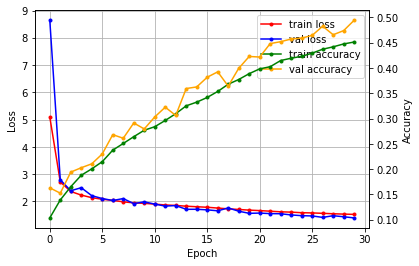

StratifiedKFold fold:2/2
train_N=25000, val_N=25000
fold:2 epoch:1/30 [tra]loss:4.6340 acc:0.1088  [val]loss:6.6843 acc:0.1275  [time]total:23.62sec tra:19.17sec val:4.45sec
fold:2 epoch:2/30 [tra]loss:2.8574 acc:0.1528  [val]loss:2.4481 acc:0.1656  [time]total:23.64sec tra:19.22sec val:4.43sec
fold:2 epoch:3/30 [tra]loss:2.4929 acc:0.1933  [val]loss:5.0399 acc:0.1966  [time]total:23.32sec tra:18.88sec val:4.44sec
fold:2 epoch:4/30 [tra]loss:2.2227 acc:0.2108  [val]loss:3.2275 acc:0.2322  [time]total:23.91sec tra:19.49sec val:4.42sec
fold:2 epoch:5/30 [tra]loss:2.1213 acc:0.2260  [val]loss:2.2124 acc:0.2537  [time]total:23.54sec tra:19.12sec val:4.43sec
fold:2 epoch:6/30 [tra]loss:2.0371 acc:0.2497  [val]loss:2.1117 acc:0.2752  [time]total:23.70sec tra:19.25sec val:4.45sec
fold:2 epoch:7/30 [tra]loss:1.9732 acc:0.2640  [val]loss:1.9783 acc:0.2856  [time]total:24.14sec tra:19.73sec val:4.41sec
fold:2 epoch:8/30 [tra]loss:1.9311 acc:0.2771  [val]loss:1.8818 acc:0.3148  [time]total:23.97s

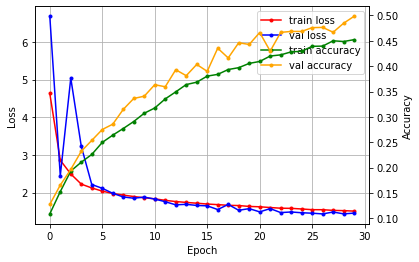

all folds score
total loss:1.423387, accuracy:0.496440
fold1/2 loss:1.394139, accuracy:0.494520
fold2/2 loss:1.452635, accuracy:0.498360

cross table


pred,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,2623,545,376,84,101,57,38,123,772,281
1,137,3658,39,56,9,68,56,106,146,725
2,483,303,1446,250,1102,196,460,524,159,77
3,155,321,317,1497,349,804,668,474,238,177
4,209,92,468,226,2328,94,588,776,144,75
5,96,231,283,1097,395,1454,333,772,221,118
6,50,181,247,363,504,55,3267,186,60,87
7,137,263,199,259,525,333,166,2756,105,257
8,581,525,71,102,55,53,34,47,3293,239


In [26]:
train_models, train_model_paths = train()

# Test

In [33]:
# test
def test(train_models):
    for model in train_models:
        model.eval()

    model_num = len(train_models)

    test_ds = torchvision.datasets.CIFAR10(root="./", train=False, download=True, transform=None)
    test_Xs = test_ds.data
    test_ys = np.array(test_ds.targets)

    dataset_test = CifarDataset(test_Xs, test_ys, transforms=transforms_val)
    dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4, shuffle=False, pin_memory=True)

    preds = []
    correct = 0

    with torch.no_grad():
         for step, batch in enumerate(dataloader_test):
            Xs = batch[0].to(device) # image
            ys = batch[1]

            _preds = np.zeros([len(ys), 10])

            for model in train_models:
                model_preds = F.softmax(model(Xs), dim=1).detach().cpu().numpy()
                _preds += model_preds / model_num

            _preds = _preds.argmax(axis=1)

            preds.extend(_preds)

            correct += sum(ys.numpy() == _preds)

    #---
    # label x pred
    #---
    res_df = pd.DataFrame({"label":test_ys, "pred":preds})
    print()
    print("cross table")
    cross = pd.crosstab(res_df["label"], res_df["pred"])

    accuracy = correct / len(test_ys)
    print(f"accuracy = {accuracy:.4f} ({correct} / {len(test_ys)})")

    display(cross)


test(train_models)

Files already downloaded and verified

cross table
accuracy = 0.5229 (5229 / 10000)


pred,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,540,105,82,13,16,2,11,25,156,50
1,19,766,8,6,0,6,10,15,31,139
2,100,58,292,55,227,30,87,107,30,14
3,34,66,61,334,54,140,130,103,49,29
4,40,21,64,40,494,13,131,157,32,8
5,18,45,47,217,77,315,62,151,48,20
6,6,26,47,57,89,7,698,45,8,17
7,46,47,33,56,61,68,31,589,18,51
8,95,103,10,26,11,7,7,5,690,46
